In [1]:
import pandas as pd

data = pd.read_csv("ai_hub_data.csv")
data

,Sentence,Emotion
0,아 진짜! 사무실에서 피지 말라니깐! 간접흡연이 얼마나 안좋은데!,분노
1,그럼 직접흡연하는 난 얼마나 안좋겠니? 안그래? 보면 꼭... 지 생각만 하고.,혐오
2,손님 왔어요.,중립
3,손님? 누구?,중립
4,몰라요. 팀장님 친구래요.,중립
...,...,...
94189,솔직히 예보 제대로 못하는 데 세금이라도 아끼게 그냥 폐지해라..,혐오
94190,재미가 없으니 망하지,혐오
94191,공장 도시락 비우생적임 아르바이트했는데 화장실가성 손도 않씯고 재료 담고 바닥 떨어...,혐오
94192,코딱지 만한 나라에서 지들끼리 피터지게 싸우는 센징 클래스 ㅉㅉㅉ,혐오


In [2]:
from transformers import BertForSequenceClassification, AutoTokenizer

model = BertForSequenceClassification.from_pretrained(
    "monologg/kobert",
    num_labels = 7
    )
tokenizer = AutoTokenizer.from_pretrained("monologg/kobert", trust_remote_code=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

In [4]:
import re

data['Sentence'] = data["Sentence"].apply(lambda x: re.sub("[^0-9a-zA-Z가-힣\s+]", "", x))

In [5]:
import pandas as pd

# label 수치화
def encoding(label):
    if label == "중립":
        return 0
    elif label == "놀람":
        return 1
    elif label == "분노":
        return 2
    elif label == "슬픔":
        return 3
    elif label == "행복":
        return 4
    elif label == "혐오":
        return 5
    elif label == "공포":
        return 6

data['Emotion'] = data['Emotion'].apply(lambda x: encoding(x))

In [6]:
data['Emotion'].value_counts()

Emotion
0    48616
1    10764
2     9293
3     7239
4     7067
5     5649
6     5566
Name: count, dtype: int64

In [7]:
data[data["Emotion"] == 0].head(20)

,Sentence,Emotion
2,손님 왔어요,0
3,손님 누구,0
4,몰라요 팀장님 친구래요,0
5,내 친구 친구 누구,0
7,그래서 무슨 일 해,0
8,그냥 방송일 조금,0
9,방송 방송 뭐,0
10,케이블 같은데서 아침에 배도 타고 산도 오르고 있어 그런 거,0
11,사는 덴 어디야,0
12,개포동,0


## 데이터셋 분리

In [8]:
from sklearn.model_selection import train_test_split 

trainX, testX, trainY, testY = train_test_split(
    data["Sentence"],
    data["Emotion"],
    test_size=0.2,
    random_state=42
)

print(f"TrainX: {trainX.shape}, TrainY: {trainY.shape}")
print(f"TestX: {testX.shape}, TestY: {testY.shape}")

TrainX: (75355,), TrainY: (75355,)
TestX: (18839,), TestY: (18839,)


In [9]:
trainX, valX, trainY, valY = train_test_split(
    trainX, trainY, test_size=0.2, random_state=42
)

print(f"TrainX: {trainX.shape}, TrainY: {trainY.shape}")
print(f"ValX: {valX.shape}, ValY: {valY.shape}")
print(f"TestX: {testX.shape}, TestY: {testY.shape}")

TrainX: (60284,), TrainY: (60284,)
ValX: (15071,), ValY: (15071,)
TestX: (18839,), TestY: (18839,)


## 토크나이징 클래스화

In [11]:
import torch 
from torch.utils.data import Dataset, DataLoader 

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts.tolist() 
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def tokenize(self, text):
        encoded_output = self.tokenizer(
            text, 
            max_length = self.max_length, # 모델이 처리할 수 있는 최대 토큰의 길이
            padding="max_length", # max_length 보다 짧을 경우 패딩 토큰을 추가하여 길이를 맞춘다
            truncation=True, # max_length 보다 길경우 자른다
            add_special_tokens=True, # bert 모델의 필요한 특수토큰을 자동으로 추가(?)
            return_token_type_ids=True, # 텍스트를 변환해서 반환할거냐 ?
            return_attention_mask=True, # 실제토큰 1 패딩토큰 0 반환
            return_tensors='pt'
        )
        return encoded_output
            
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # 데이터 가져오기
        text = self.texts[idx]
        label = self.labels[idx]

        # 토크나이징
        encoding = self.tokenize(text)

        # 라벨 추가
        # encoding["label"] = torch.tensor(label, dtype=torch.long)

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "token_type_ids": encoding["token_type_ids"].flatten(),
            "label": torch.tensor(label, dtype=torch.long)
        }

In [12]:
max_length = 128
train_dataset = CustomDataset(trainX, trainY, tokenizer, max_length)
val_dataset = CustomDataset(valX, valY, tokenizer, max_length)
test_dataset = CustomDataset(testX, testY, tokenizer, max_length)

In [13]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

In [68]:
# import torch
# import torch.nn as nn
# from transformers import AutoModel

# class CustomKoBERT(nn.Module): # pyTorch의 nn.Module을 상속하여 클래스 정의
#     def __init__(self, num_labels):
#         super(CustomKoBERT, self).__init__()
#         self.bert = AutoModel.from_pretrained("monologg/kobert")
#         self.classifier = nn.Linear(768, num_labels)  #분류 헤드 정의: BERT의 출력(768차원)을 입력으로, 분류할 클래스 개수만큼 출력생성하는 nn.linear정의
#         self.loss_fn = nn.CrossEntropyLoss()  # 손실 함수 정의

#     def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
#         # BERT 모델의 출력
#         outputs = self.bert(input_ids=input_ids,
#                             attention_mask=attention_mask,
#                             token_type_ids=token_type_ids)
#         pooled_output = outputs[1]  # KoBERT 의 두번째 값인 pooled_output을 가져옴 이것은? -> 문장의 전체의미를 요약한 벡터
        
#         # 분류 헤드 통과
#         logits = self.classifier(pooled_output)  # 전체의미를요약한 벡터를 분류기에 넣어서 분류결과를 생성
        
#         # 손실 계산 (labels가 주어진 경우)
#         loss = None
#         if labels is not None:
#             loss = self.loss_fn(logits, labels) # 예측값과 라벨과 손실 값을 계산

#         return {"loss": loss, "logits": logits} # train 중에는 손실 값 사용 / 추론 시 불류 결과 사용


In [14]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

In [ ]:
# import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# device = f"cuda:{1}" if torch.cuda.is_available() else "cpu"

# print('Device:', device)  # 출력결과: cuda 
# print('Count of using GPUs:', torch.cuda.device_count())   #출력결과: 2 (2, 3 두개 사용하므로)
# print('Current cuda device:', torch.cuda.current_device())  # 출력결과: 2 (2, 3 중 앞의 GPU #2 의미)

Device: cuda:1
Count of using GPUs: 1
Current cuda device: 0


In [ ]:
# # 소요되는 시간 산정해보기

# from torch.optim import AdamW
# from transformers import get_linear_schedule_with_warmup
# from torch.nn.utils import clip_grad_norm_
# import torch
# import time  # 시간 측정을 위한 모듈

# device = "cuda" if torch.cuda.is_available() else "cpu"

# # 하이퍼 파라미터 설정
# epochs = 10
# optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

# # 스케줄러 설정
# total_steps = len(train_loader) * epochs
# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=500,
#     num_training_steps=total_steps
# )

# loss_history = {"train": [], "validation": []}
# patience = 5
# patience_cnt = 0
# best_loss_val = float('inf')
# model = model.to(device)

# # epoch 전 시작시간 기록
# start_time = time.time()

# for epoch in range(epochs):
#     #### Train ####
#     model.train()

#     loss_train = 0.0
#     for batch in train_loader:
#         # GPU 보내기
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         token_type_ids = batch['token_type_ids'].to(device)
#         labels = batch['label'].to(device)

#         # 학습과정
#         optimizer.zero_grad()
#         outputs = model(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             token_type_ids=token_type_ids,
#             labels=labels 
#         )
#         loss = outputs.loss
#         loss.backward()
#         # 기울기 폭주 방지
#         clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
#         scheduler.step()

#         # loss 저장
#         loss_train += loss.item() * batch_size
#     loss_history['train'].append(loss_train / len(train_dataset))

#     #### Validation ####

#     model.eval()

#     loss_val = 0.0
#     for batch in val_loader:
#         # GPU 보내기
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         token_type_ids = batch['token_type_ids'].to(device)
#         labels = batch['label'].to(device)

#         with torch.no_grad():
#             outputs = model(
#                 input_ids=input_ids,
#                 attention_mask=attention_mask,
#                 token_type_ids=token_type_ids,
#                 labels=labels 
#             )
#             loss = outputs.loss
#         loss_val += loss.item() * batch_size
#     loss_history['validation'].append(loss_val / len(val_dataset))

#     #### Early Stopping ####
#     if loss_val < best_loss_val:
#         best_loss_val = loss_val
#         torch.save(model.state_dict(), "team1_test.pth")
#         patience_cnt += 1
#         if patience_cnt == patience:
#             print("Early stopping!")
#             break

#     if epoch % 2 == 0:
#         print(f"epoch: {epoch}, Train_loss: {loss_train/len(train_dataset)}, Validation_loss: {loss_val / len(val_dataset)}")

# # 학습 종료 시간 기록 및 학습 시간 계산
# end_time = time.time()
# elapsed_time = end_time - start_time

# # 학습 시간 출력 (초 단위로 출력)
# print(f"Total training time: {elapsed_time:.2f} seconds")


epoch: 0, Train_loss: 1.2186526687750652, Validation_loss: 1.0501681754255443
epoch: 2, Train_loss: 0.7964334391731311, Validation_loss: 1.0364219574912148
epoch: 4, Train_loss: 0.4722095432171389, Validation_loss: 1.3115983276691174
epoch: 6, Train_loss: 0.2667124072578842, Validation_loss: 1.6156558333644901
epoch: 8, Train_loss: 0.1594816120932805, Validation_loss: 1.8473195127940638
Total training time: 1346.22 seconds


In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.nn.utils import clip_grad_norm_
import torch
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

# 하이퍼 파라미터 설정

epochs = 10
optimizer = AdamW(model.parameters(), lr = 2e-5, weight_decay=0.01) # 손실함수에 가중치 정형화 적용해보기 .. 일단 작게 0.01 만.. 언더피팅 안나게 ..

# 스케줄러 설정
# 워밍업 단계(학습률을 선형적으로 증가) / 학습 단계(학습률을 선형적으로 감소)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 500,
    num_training_steps = total_steps
)

loss_history = {"train" : [], "validation" : []}
patience = 5
patience_cnt = 0
best_loss_val = float('inf')
model = model.to(device)

for epoch in range(epochs):
    #### Train ####
    model.train()

    loss_train = 0.0
    for batch in train_loader:
        # GPU 보내기
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['label'].to(device)

        # 학습과정
        optimizer.zero_grad()
        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids,
            labels = labels 
        )
        loss = outputs.loss
        loss.backward()
        # 기울기 폭주(exploration)
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        # loss 저장
        loss_train += loss.item() * batch_size
    loss_history['train'].append(loss_train / len(train_dataset))

    #### Validation ####

    model.eval()

    loss_val = 0.0
    for batch in val_loader:
        # GPU 보내기
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['label'].to(device)

        with torch.no_grad():
            outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids,
            labels = labels 
            )
            loss = outputs.loss
        loss_val += loss.item() * batch_size
    loss_history['validation'].append(loss_val / len(val_dataset))

    #### Early Stopping ####
    if loss_val < best_loss_val:
        best_loss_val = loss_val
        torch.save(model.state_dict(), "REALtest.pth")
        patience_cnt += 1
        if patience_cnt == patience:
            print("Early stopping!")
            break

    if epoch % 2 == 0 :
        print(f"epoch: {epoch}, Train_loss: {loss_train/len(train_dataset)}, Validation_loss: {loss_val / len(val_dataset)}")

epoch: 0, Train_loss: 1.304146728378943, Validation_loss: 1.1097014402316503
epoch: 2, Train_loss: 0.8928535645060767, Validation_loss: 1.020756829639997
epoch: 4, Train_loss: 0.6916064365914202, Validation_loss: 1.0973090971088086
epoch: 6, Train_loss: 0.5322882185791635, Validation_loss: 1.2097582168786656
epoch: 8, Train_loss: 0.4261204054831636, Validation_loss: 1.3196048687214827


In [72]:
# from torch.optim import AdamW
# from transformers import get_linear_schedule_with_warmup
# from torch.nn.utils import clip_grad_norm_

# # CustomKoBERT 모델 생성
# num_labels = 7
# batch_size = 8
# epochs = 50
# model = CustomKoBERT(num_labels=num_labels).to(device)

# # Optimizer 및 스케줄러 설정 (변경 없음)
# optimizer = AdamW(model.parameters(), lr=0.001)
# total_steps = len(train_loader) * epochs
# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=0,
#     num_training_steps=total_steps
# )
# loss_history = {"train": [], "validation" : []}
# patience = 7
# patience_cnt = 0
# best_loss_val = float('inf')

# # 학습 루프 (변경 없음)
# for epoch in range(epochs):
#     model.train()
#     loss_train = 0.0

#     for batch in train_loader:
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         token_type_ids = batch['token_type_ids'].to(device)
#         labels = batch['label'].to(device)

#         optimizer.zero_grad()
        
#         # Forward pass (loss와 logits 반환)
#         outputs = model(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             token_type_ids=token_type_ids,
#             labels=labels
#         )
        
#         loss = outputs["loss"]
#         loss.backward()

#         clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
#         scheduler.step()

#         loss_train += loss.item() * batch_size

#     loss_history['train'].append(loss_train / len(train_dataset))

#     #### Validation ####
#     model.eval()
#     loss_val = 0.0

#     for batch in val_loader:
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         token_type_ids = batch['token_type_ids'].to(device)
#         labels = batch['label'].to(device)

#         with torch.no_grad():
#             outputs = model(
#                 input_ids=input_ids,
#                 attention_mask=attention_mask,
#                 token_type_ids=token_type_ids,
#                 labels=labels
#             )
#             loss = outputs["loss"]

#         loss_val += loss.item() * batch_size

#     loss_history['validation'].append(loss_val / len(val_dataset))

#     #### Early Stopping ####
#     if loss_val < best_loss_val:
#         best_loss_val = loss_val
#         torch.save(model.state_dict(), "Bert_best_model.pth")
#         patience_cnt += 1
#         if patience_cnt == patience:
#             print("Early stopping!")
#             break

#     print(f"epoch: {epoch}, Train_loss: {loss_train/len(train_dataset)}, Validation_loss: {loss_val / len(val_dataset)}")


/tmp/ipykernel_1762636/3637709931.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


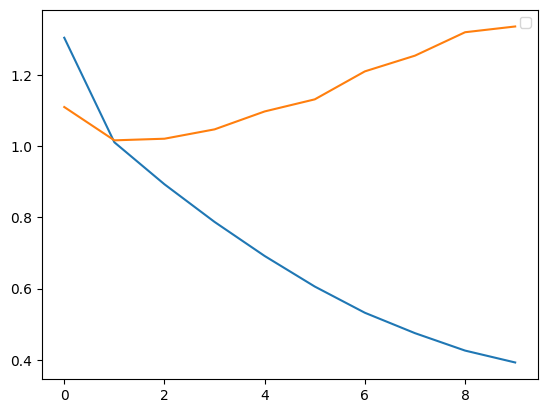

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')

plt.plot(loss_history['train'], label='Train Loss')
plt.plot(loss_history['validation'], label='Validation Loss')
plt.title('loss 비교')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show

In [ ]:
model = BertForSequenceClassification.from_pretrained("monologg/kobert", num_labels=7)
tokenizer = AutoTokenizer.from_pretrained("monologg/kobert")
model.load_state_dict(torch.load("REALtest.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Test ####

model.to(device)
model.eval()

loss_test = 0.0
correct = 0
with torch.no_grad():
    for batch in test_loader:
        # gpu 보내기
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['label'].to(device)
        # print(input_ids)
        # print(attention_mask)
        # print(token_type_ids)

        # 예측
        outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask,
        token_type_ids = token_type_ids,
        labels = labels 
        )
        
        loss = outputs.loss
        preds = outputs.logits.argmax(dim=1)
        correct += (labels == preds).sum()

        # loss 저장
        loss_test += loss.item() * batch_size
print(f"Test Loss: {loss_test / len(test_dataset)}, Accuracy: {correct / len(test_dataset)}")

NameError: name 'test_loader' is not defined

In [23]:
import torch
from transformers import BertForSequenceClassification, AutoTokenizer

# 모델 및 토크나이저 로드
model = BertForSequenceClassification.from_pretrained("monologg/kobert", num_labels=7)
tokenizer = AutoTokenizer.from_pretrained("monologg/kobert")
model.load_state_dict(torch.load("REALtest.pth"))

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 입력 텍스트 토큰화
text = "너무 막막하네"
encoded_input = tokenizer(text, return_tensors="pt")
encoded_input = {key: val.to(device) for key, val in encoded_input.items()}

# 모델 호출 및 출력 처리
outputs = model(**encoded_input)
print(outputs.logits.argmax(dim=1).item())


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1789392/285093464.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We re

3


In [13]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
print(torch.cuda.get_device_name(device))

Available devices  2
Current cuda device  0
NVIDIA GeForce RTX 4090
